In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
N=1000

In [4]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 10, N, dtype=torch.float64)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [5]:
train_x.shape, train_y.shape

(torch.Size([1000]), torch.Size([1000]))

In [12]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.PeriodicKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# As we are using float64 data, we need to convert our model to double
model.double()
likelihood.double()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   num mixtures: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

/Users/lgo/dev/kuleuven/thesis_wip/venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


Iter 1/200 - Loss: 1.136   num mixtures: 0.693   noise: 0.693
Iter 2/200 - Loss: 1.122   num mixtures: 0.744   noise: 0.644
Iter 3/200 - Loss: 1.115   num mixtures: 0.798   noise: 0.599
Iter 4/200 - Loss: 1.114   num mixtures: 0.822   noise: 0.557
Iter 5/200 - Loss: 1.111   num mixtures: 0.845   noise: 0.521
Iter 6/200 - Loss: 1.103   num mixtures: 0.861   noise: 0.493
Iter 7/200 - Loss: 1.101   num mixtures: 0.881   noise: 0.473
Iter 8/200 - Loss: 1.114   num mixtures: 0.899   noise: 0.462
Iter 9/200 - Loss: 1.118   num mixtures: 0.905   noise: 0.460
Iter 10/200 - Loss: 1.110   num mixtures: 0.919   noise: 0.466
Iter 11/200 - Loss: 0.977   num mixtures: 0.945   noise: 0.477
Iter 12/200 - Loss: 0.660   num mixtures: 0.984   noise: 0.479
Iter 13/200 - Loss: 0.715   num mixtures: 1.029   noise: 0.464
Iter 14/200 - Loss: 0.836   num mixtures: 1.046   noise: 0.443
Iter 15/200 - Loss: 0.794   num mixtures: 1.043   noise: 0.420
Iter 16/200 - Loss: 0.619   num mixtures: 1.024   noise: 0.396
I

Iter 133/200 - Loss: 0.028   num mixtures: 1.010   noise: 0.042
Iter 134/200 - Loss: -0.101   num mixtures: 1.005   noise: 0.042
Iter 135/200 - Loss: -0.112   num mixtures: 0.995   noise: 0.043
Iter 136/200 - Loss: 0.015   num mixtures: 0.990   noise: 0.043
Iter 137/200 - Loss: -0.144   num mixtures: 0.997   noise: 0.044
Iter 138/200 - Loss: -0.108   num mixtures: 1.005   noise: 0.045
Iter 139/200 - Loss: -0.021   num mixtures: 1.009   noise: 0.046
Iter 140/200 - Loss: -0.132   num mixtures: 1.003   noise: 0.047
Iter 141/200 - Loss: -0.149   num mixtures: 0.998   noise: 0.047
Iter 142/200 - Loss: -0.122   num mixtures: 0.995   noise: 0.048
Iter 143/200 - Loss: -0.126   num mixtures: 0.996   noise: 0.048
Iter 144/200 - Loss: -0.151   num mixtures: 1.000   noise: 0.048
Iter 145/200 - Loss: -0.155   num mixtures: 1.000   noise: 0.048
Iter 146/200 - Loss: -0.155   num mixtures: 0.999   noise: 0.048
Iter 147/200 - Loss: -0.157   num mixtures: 0.999   noise: 0.047
Iter 148/200 - Loss: -0.154

In [14]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 980, dtype=torch.float64)
    observed_pred = likelihood(model(test_x))

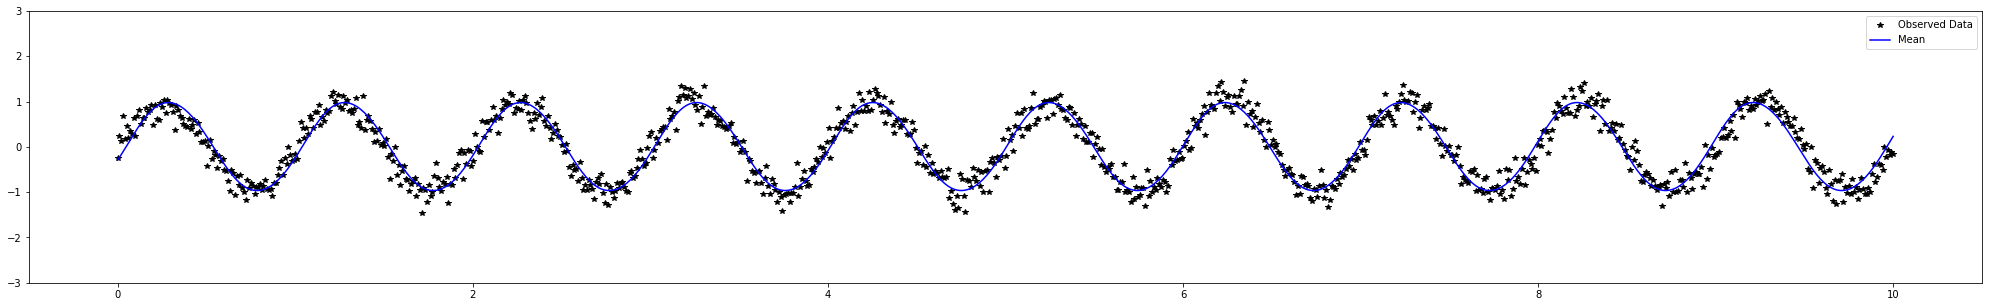

In [15]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(35, 5))

    # Get upper and lower confidence bounds
#    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
#    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])